# Metal 3-D Printing
***
The [video](https://drive.google.com/open?id=1N1sdoeqEVSU-bpe1Bb66Bt34C_x8CTkK) shows the process of 3-D printing of powdered metal. Our goal is to predict the percentage of the powder stream that is actually deposited. This can be achieved by identifying the various different kinds of activities taking place in the deposition process-

* molten material splashing
* vaporized material
* ricocheting without melting 

The initial first hand goal is to find the number and size of the material that ricochets away. The intuition is that we can find the rate at which the material is flowing in, and by having determined the approximate quantity of the splashed material using the image processing techniques we will be able to determine the actual material deposition.

## Histogram 

In the below program we examine the histogram of the individual frames to gain some insight. 

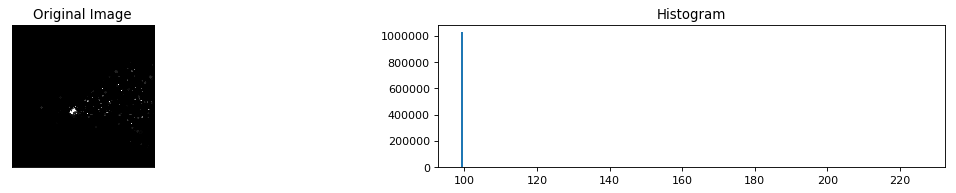

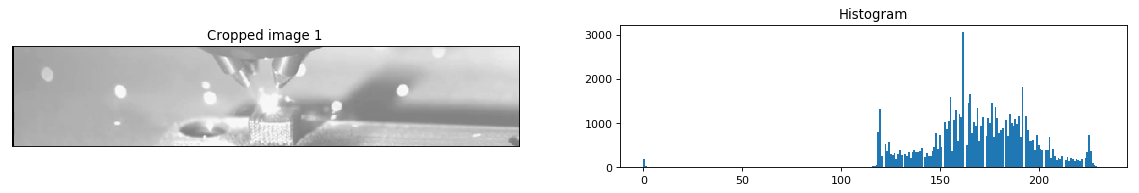

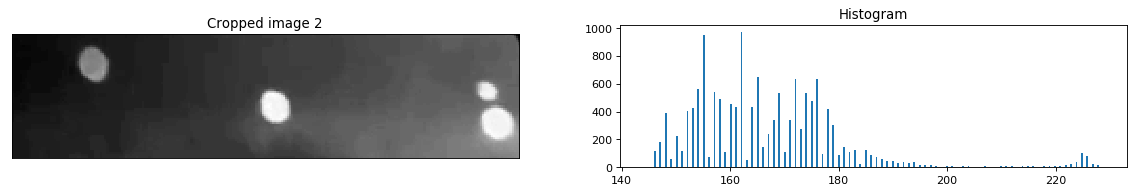

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# cv2.imread()
# second argument is a flag which specifies the way image should be read.
# (1) - cv2.IMREAD_COLOR : Loads a color image. Any transparency of image will be neglected. It is the default flag.
# (0) - cv2.IMREAD_GRAYSCALE : Loads image in grayscale mode
# (-1) - cv2.IMREAD_UNCHANGED : Loads image as such including alpha channel

img1 = cv2.imread('images/IR_623.png',0)
img2 = cv2.imread('images/1b.png',0)
img3 = cv2.imread('images/1a.png',0)

# plot all the images and their histograms
images = [img1, 0,img2, 0,img3, 0]
titles = ['Original Image','Histogram','Cropped image 1','Histogram','Cropped image 2','Histogram']

for i in range(3):
    plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(3,2,i*2+1),plt.imshow(images[i*2],'gray')
    plt.title(titles[i*2]),plt.xticks([]), plt.yticks([])
    plt.subplot(3,2,i*2+2),plt.hist(images[i*2].ravel(),256)
    # numpy.ravel() returns a straightened 1-D linear array
    plt.title(titles[i*2+1])
plt.show()

## OTSU's method

The histograms obtained above shows that the given image is not bimodal, hence the OTSU's algorithm may not work properly. Below cell implements the OTSU's thresholding algorithm, and as expected it doesn't work out well.

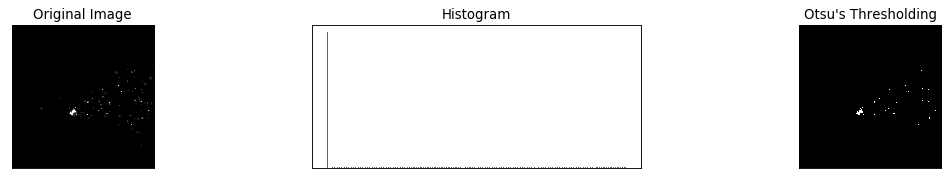

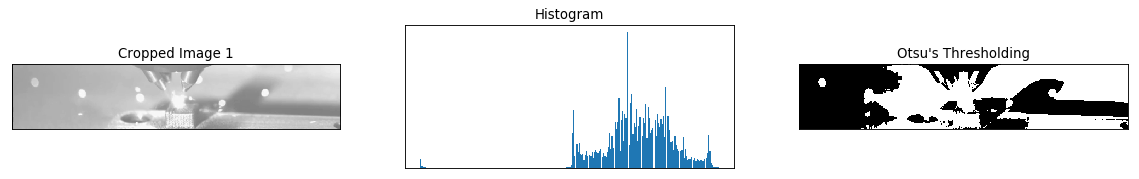

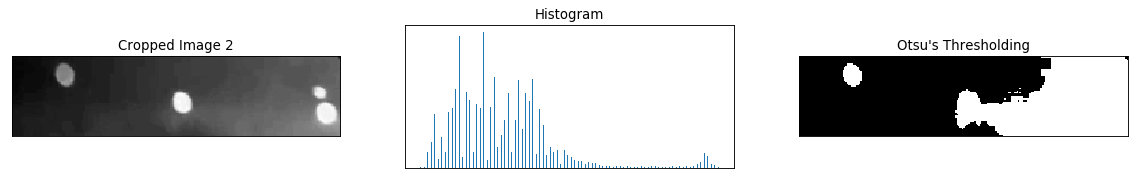

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('images/IR_623.png',0)
img2 = cv2.imread('images/1b.png',0)
img3 = cv2.imread('images/1a.png',0)

# Otsu's thresholding
ret1,th1 = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,th2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,th3 = cv2.threshold(img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img1, 0, th1,
          img2, 0, th2,
          img3, 0, th3]
titles = ['Original Image','Histogram',"Otsu's Thresholding",
          'Cropped Image 1','Histogram',"Otsu's Thresholding",
          'Cropped Image 2','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

## Simple thresholding

The threshold value is set manually by hit and trial in order to obtain the required background seperation.

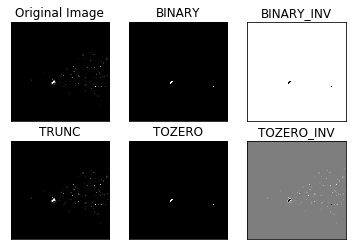

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/IR_623.png',0)
threshold = 200 # value set by hit and trial
ret,thresh1 = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,threshold,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,threshold,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,threshold,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

## Adaptive Thresholding

Subplot 3 from the figure below (Adaptive mean thresholding) can be de-noised and can be used to find the circular regions. 
Hough circle tranform is giving accurate results for the cropped image (as it can be seperated nicely) while with the full image there are many misses and false alarms.

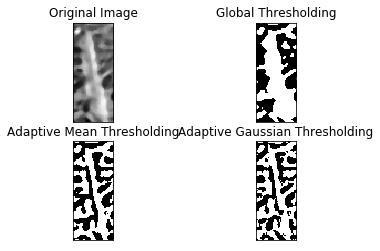

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('3img.png',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding','Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

## Hough's Circle Identification

In this method we have used the adapative mean threshold along with some denoising filters (median blur) to obtain the foreground. Later we have used the houghs method to mark the circles.

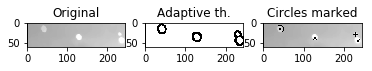

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/1a.png',0)
img = cv2.medianBlur(img,5)

th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

#kernel = np.ones((5,5),np.float32)/25
#dst = cv2.filter2D(th2,-1,kernel)
median = cv2.medianBlur(th2,5)

plt.subplot(131)
plt.title("Original")
plt.imshow(img,'gray')

plt.subplot(132)
plt.title("Adaptive th.")
plt.imshow(median,'gray')

# Houghs method
circles = cv2.HoughCircles(median, cv2.HOUGH_GRADIENT, 1, median.shape[0] / 8, param1=60, param2=10,minRadius=1, maxRadius=15)
#draw
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(img, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(img, center, radius, (0, 0, 0), 1)
# print(circles)
#display
plt.subplot(133)
plt.imshow(img,'gray')
plt.title("Circles marked")
plt.show()
